📌 INFO DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None

📌 DESKRIPSI FITUR NUMERIK
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      342.000000     342.000000         342.000000   342.000000
mean        43.921930      17.151170         200.915205  4201.754386
std          5.459584       1.974793          14.061714   801.954536
min         32.100000      13.100000         172.000000  2700.000000
25%         39.2250

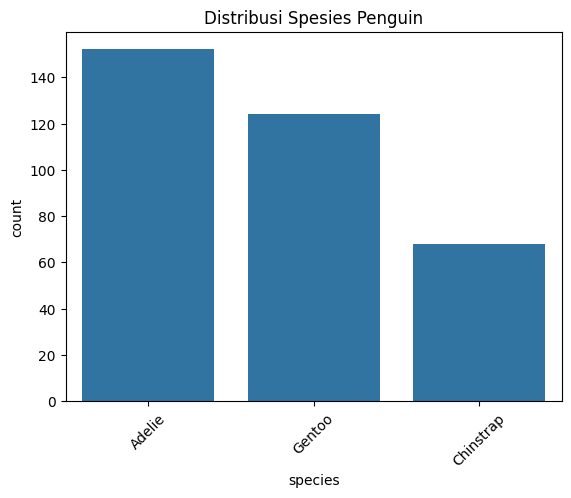

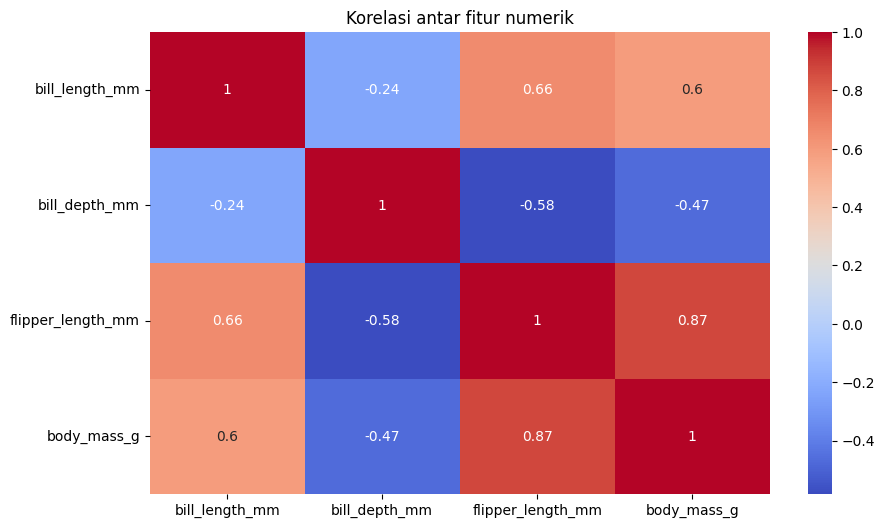

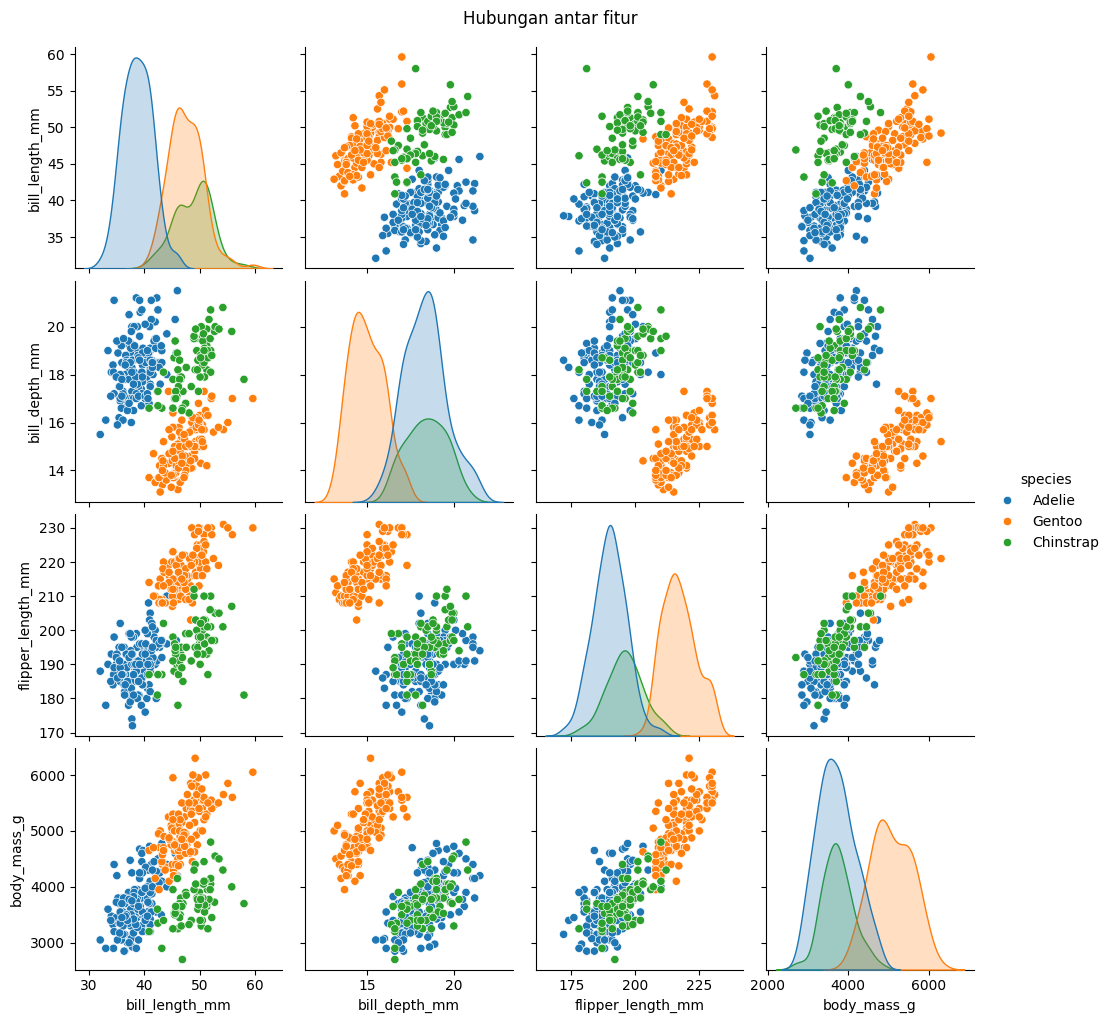

✅ Train Accuracy: 0.9945
✅ Test Accuracy: 0.9855


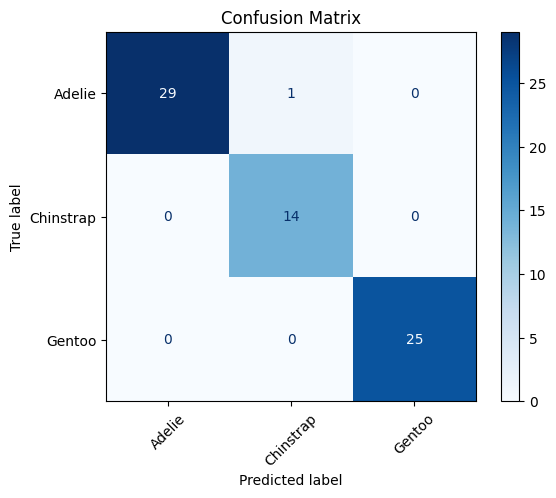

📊 Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.98        30
   Chinstrap       0.93      1.00      0.97        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.99        69
   macro avg       0.98      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69

✅ Model, scaler, dan label encoder berhasil disimpan.


In [1]:
# Import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib

# Load data
df = pd.read_csv("/content/penguins.csv")

# ---------------------------- EDA ----------------------------

print("📌 INFO DATASET")
print(df.info())
print("\n📌 DESKRIPSI FITUR NUMERIK")
print(df.describe())

# Missing values
print("\n📌 MISSING VALUE")
print(df.isna().sum())

# Distribusi target
sns.countplot(data=df, x='species')
plt.title("Distribusi Spesies Penguin")
plt.xticks(rotation=45)
plt.show()

# Korelasi numerik
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar fitur numerik")
plt.show()

# Pairplot
sns.pairplot(df, hue='species')
plt.suptitle("Hubungan antar fitur", y=1.02)
plt.show()

# ---------------------------- PREPROCESSING ----------------------------

# Drop baris full NaN
df.dropna(how='all', inplace=True)

# Encode target
le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])

# One-hot encoding fitur kategorikal
df_encoded = pd.get_dummies(df, columns=['island', 'sex'])

# Pisahkan fitur dan label
X = df_encoded.drop('species', axis=1)
y = df_encoded['species']

# Imputasi KNN
imputer = KNNImputer()
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE balancing
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# ---------------------------- MODELING ANTI-OVERFIT ----------------------------

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=3,
    random_state=42
)

rf_model.fit(X_train_bal, y_train_bal)

# Evaluasi
y_pred = rf_model.predict(X_test_scaled)
acc_train = accuracy_score(y_train_bal, rf_model.predict(X_train_bal))
acc_test = accuracy_score(y_test, y_pred)

print(f"✅ Train Accuracy: {acc_train:.4f}")
print(f"✅ Test Accuracy: {acc_test:.4f}")

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap='Blues')
disp.ax_.set_title('Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# ---------------------------- SIMPAN MODEL ----------------------------

joblib.dump(rf_model, "model_penguin.pkl")
joblib.dump(scaler, "scaler_penguin.pkl")
joblib.dump(le, "label_encoder_penguin.pkl")

print("✅ Model, scaler, dan label encoder berhasil disimpan.")


In [2]:
# Cek akurasi
print(f"Train Accuracy: {accuracy_score(y_train_bal, rf_model.predict(X_train_bal)):.4f}")
print(f"Test Accuracy : {accuracy_score(y_test, rf_model.predict(X_test_scaled)):.4f}")

Train Accuracy: 0.9945
Test Accuracy : 0.9855


In [3]:
from sklearn.model_selection import cross_val_score

# Cross-validation pada data training (yang sudah di-SMOTE dan di-scale)
cv_scores = cross_val_score(
    rf_model,
    X_train_bal,
    y_train_bal,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy'
)

# Hasil evaluasi
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy      : {cv_scores.mean():.4f}")
print(f"Standard deviation    : {cv_scores.std():.4f}")

Cross-validation scores: [0.98648649 1.         0.97260274 1.         0.98630137]
Mean CV accuracy      : 0.9891
Standard deviation    : 0.0102
